In [81]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [84]:
set_training = pd.read_csv('data/aps_failure_training_set.csv')
set_training.pop('id')

columns = pd.Series(set_training.columns)

counts = columns.apply(lambda x: x.split("_")[0]).value_counts().to_dict()
classes_columns_idx = columns.apply(
    lambda x: True if counts[x.split("_")[0]] > 1 else False)

classes_columns = columns[classes_columns_idx]
classes_columns.apply(lambda x: x.split("_")[0]).value_counts().to_dict()

classes_trainning = set_training.copy()

classes_trainning["class"] = classes_trainning["class"].replace(['neg', 'pos'], [0, 1])
classes_trainning = classes_trainning.replace('na', 0).astype(float).corr()
labels = set_training.pop('class')

numerical_columns = columns[~classes_columns_idx]
numerical_columns = numerical_columns[2:]

classes_trainning["class"].abs()[numerical_columns].sort_values(ascending=False).plot(kind='bar')
column_relevant = classes_trainning["class"].abs()[numerical_columns].sort_values(ascending=False) > 0.3

relevant_numerical_columns = column_relevant[column_relevant].index


other_columns = pd.Index(classes_columns).append(pd.Index(relevant_numerical_columns))





In [14]:


target_value = labels.apply(lambda x: 1 if x == 'pos' else 0).values
X = set_training[classes_columns].replace('na', 0).astype(int).values

X_transformed = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, target_value, test_size=0.33, random_state=42, stratify=target_value)
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
clf.fit(X_train, y_train)

c:\Users\mt_er\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial', random_state=0)

In [16]:
target_prediction = clf.predict(X_test)

print(classification_report(y_test, target_prediction))
print(confusion_matrix(y_test, target_prediction))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19470
           1       0.76      0.54      0.63       330

    accuracy                           0.99     19800
   macro avg       0.87      0.77      0.81     19800
weighted avg       0.99      0.99      0.99     19800

[[19413    57]
 [  152   178]]


In [17]:
test_df = pd.read_csv('data/aps_failure_test_set.csv')
X = test_df[classes_columns].replace('na', 0).astype(int).values
X_transformed = StandardScaler().fit_transform(X)
target_prediction_ = clf.predict(X_transformed)

In [18]:
def labelize(x):
    if x == 1:
        return 'pos'
    else:
        return 'neg'
labelize = np.vectorize(labelize)

In [19]:
output = pd.DataFrame({'id': np.arange(1,len(target_prediction_)+1),"class": labelize(target_prediction_)})
output.to_csv('categorical values standardized logistic regression, output.csv', index=False)

In [20]:
from functionLDA import LDA

In [21]:
X = set_training[other_columns].replace('na', 0).astype(float).values
X_transformed = StandardScaler().fit_transform(X)
lda = LDA(70)
lda.fit(X_transformed, target_value)
X_transformed_ = lda.transform(X_transformed)
X_train, X_test, y_train, y_test = train_test_split(X_transformed_, target_value, test_size=0.33, random_state=42, stratify=target_value)

(60000, 97) (97, 70)


In [23]:
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='binary:logistic', booster='gbtree')
clf.fit(X_train, y_train)
target_prediction = clf.predict(X_test)

print(classification_report(y_test, target_prediction))

print(confusion_matrix(y_test, target_prediction))

c:\Users\mt_er\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:09:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19470
           1       0.81      0.65      0.72       330

    accuracy                           0.99     19800
   macro avg       0.90      0.82      0.86     19800
weighted avg       0.99      0.99      0.99     19800

[[19419    51]
 [  115   215]]


In [24]:
#use keras to create a neural network
from tensorflow import keras
from keras.models import Sequential
#use momentum optimizer
from keras.optimizers.legacy import Adam



In [26]:

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(classes=np.unique(target_value), y=target_value, class_weight='balanced')

cw = {0: float(class_weights[0]), 1: float(class_weights[1])}

In [31]:
X = set_training[other_columns].replace('na', 0).astype(float).values
X_transformed = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, target_value, test_size=0.33, random_state=42, stratify=target_value)

In [33]:
#create encoder decoder model for the data 6 layers deep
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

import tensorflow as tf

def custom_sigmoid(x):
    return 2 * (1 / (1 + tf.exp(-x))) - 1

input_df = Input(shape=(X_transformed.shape[1],))
encoded = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-6),
                activity_regularizer=regularizers.l1(1e-6))(input_df)

encoded = Dense(48, activation='relu', kernel_regularizer=regularizers.l2(1e-6),
                activity_regularizer=regularizers.l1(1e-6))(encoded)

decoded = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-6),
                activity_regularizer=regularizers.l1(1e-6))(encoded)
decoded = Dense(X_transformed.shape[1], activation=custom_sigmoid)(decoded)

autoencoder = Model(input_df, decoded)
encoder = Model(input_df, encoded)
adam = Adam(learning_rate=1e-3, clipvalue=0.5)
autoencoder.compile(optimizer=adam, loss='mean_squared_error')
autoencoder.fit(X_transformed, X_transformed, epochs=100, batch_size=128, validation_data=(X_test, X_test))

Epoch 1/100
469/469 [==============================] - 2s 3ms/step - loss: 0.7900 - val_loss: 0.6981
Epoch 2/100
469/469 [==============================] - 1s 3ms/step - loss: 0.7626 - val_loss: 0.6917
Epoch 3/100
469/469 [==============================] - 1s 3ms/step - loss: 0.7584 - val_loss: 0.6887
Epoch 4/100
469/469 [==============================] - 1s 3ms/step - loss: 0.7561 - val_loss: 0.6868
Epoch 5/100
469/469 [==============================] - 1s 3ms/step - loss: 0.7545 - val_loss: 0.6859
Epoch 6/100
469/469 [==============================] - 1s 3ms/step - loss: 0.7537 - val_loss: 0.6870
Epoch 7/100
469/469 [==============================] - 1s 3ms/step - loss: 0.7531 - val_loss: 0.6844
Epoch 8/100
469/469 [==============================] - 2s 3ms/step - loss: 0.7526 - val_loss: 0.6839
Epoch 9/100
469/469 [==============================] - 1s 3ms/step - loss: 0.7532 - val_loss: 0.6840
Epoch 10/100
469/469 [==============================] - 2s 3ms/step - loss: 0.7518 - val_lo

In [34]:
#create XGBoost model
import xgboost as xgb
clf = xgb.XGBClassifier()
clf.fit(encoder.predict(X_train), y_train)
target_prediction = clf.predict(encoder.predict(X_test))

print(classification_report(y_test, target_prediction))

print(confusion_matrix(y_test, target_prediction))

619/619 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19470
           1       0.80      0.67      0.73       330

    accuracy                           0.99     19800
   macro avg       0.90      0.83      0.86     19800
weighted avg       0.99      0.99      0.99     19800

[[19414    56]
 [  109   221]]


In [35]:
#create a predictor deep neural network

def get_predictor_model():
    model = Sequential()

    model.add(Dense(32, input_dim=48,
                    activation='relu',
                    kernel_regularizer=regularizers.l2(1e-5),
                    activity_regularizer=regularizers.l1(1e-5)))
    
    model.add(Dense(32, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-5),
                    activity_regularizer=regularizers.l1(1e-5)))
    
    model.add(Dense(32, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-5),
                    activity_regularizer=regularizers.l1(1e-5)))
    model.add(Dense(32, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-5),
                    activity_regularizer=regularizers.l1(1e-5)))
    
    model.add(Dense(32, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-5),
                    activity_regularizer=regularizers.l1(1e-5)))
    model.add(Dense(32, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-5),
                    activity_regularizer=regularizers.l1(1e-5)))
    
    model.add(Dense(32, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-5),
                    activity_regularizer=regularizers.l1(1e-5)))
    model.add(Dense(32, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-5),
                    activity_regularizer=regularizers.l1(1e-5)))
    model.add(Dense(32, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-5),
                    activity_regularizer=regularizers.l1(1e-5)))
    model.add(Dense(32, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-5),
                    activity_regularizer=regularizers.l1(1e-5)))
    model.add(Dense(32, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-5),
                    activity_regularizer=regularizers.l1(1e-5)))
    model.add(Dense(16, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-5),
                    activity_regularizer=regularizers.l1(1e-5)))
    
    model.add(Dense(8, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-5),
                    activity_regularizer=regularizers.l1(1e-5)))
    
    model.add(Dense(1, activation='sigmoid'))
    

    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [36]:
preditctor = get_predictor_model()

c:\Users\mt_er\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [37]:
preditctor.fit(encoder.predict(X_train), y_train, epochs=100, batch_size=128, validation_data=(encoder.predict(X_test), y_test))

619/619 [==============================] - 1s 1ms/step
Epoch 1/100
315/315 [==============================] - 4s 6ms/step - loss: 0.4150 - accuracy: 0.9828 - val_loss: 0.1183 - val_accuracy: 0.9833
Epoch 2/100
315/315 [==============================] - 2s 5ms/step - loss: 0.0603 - accuracy: 0.9846 - val_loss: 0.0439 - val_accuracy: 0.9849
Epoch 3/100
315/315 [==============================] - 2s 5ms/step - loss: 0.0420 - accuracy: 0.9853 - val_loss: 0.0403 - val_accuracy: 0.9859
Epoch 4/100
315/315 [==============================] - 2s 5ms/step - loss: 0.0387 - accuracy: 0.9863 - val_loss: 0.0389 - val_accuracy: 0.9862
Epoch 5/100
315/315 [==============================] - 1s 5ms/step - loss: 0.0369 - accuracy: 0.9874 - val_loss: 0.0378 - val_accuracy: 0.9872
Epoch 6/100
315/315 [==============================] - 2s 5ms/step - loss: 0.0352 - accuracy: 0.9879 - val_loss: 0.0365 - val_accuracy: 0.9876
Epoch 7/100
315/315 [==============================] - 1s 5ms/step - loss: 0.0340 - acc

In [38]:
target_prediction = preditctor.predict(encoder.predict(X_test))
target_prediction = np.round(target_prediction)

print(classification_report(y_test, target_prediction))

print(confusion_matrix(y_test, target_prediction))


619/619 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19470
           1       0.74      0.63      0.68       330

    accuracy                           0.99     19800
   macro avg       0.87      0.81      0.84     19800
weighted avg       0.99      0.99      0.99     19800

[[19396    74]
 [  123   207]]


In [39]:
X_transformed.shape

(60000, 97)

In [40]:
#add ln and exp of numerical columns and look at the correlation
log_df = set_training[numerical_columns].replace('na', 0).astype(float).apply(np.log)
log_df = log_df.replace(-np.inf, 0)
log_df = log_df.replace(np.inf, 0)
log_df = log_df.replace(np.nan, 0)

exp_df = set_training[numerical_columns].replace('na', 0).astype(float).apply(np.exp)
exp_df = exp_df.replace(-np.inf, 0)
exp_df = exp_df.replace(np.inf, 0)
exp_df = exp_df.replace(np.nan, 0)

#create a new pandas df with the log and exp columns and name them accordingly
log_df.columns = log_df.columns.map(lambda x: 'log_' + x)
exp_df.columns = exp_df.columns.map(lambda x: 'exp_' + x)

#concatenate the log and exp columns with the original df
set_training = pd.concat([set_training, log_df, exp_df], axis=1)

In [42]:
#corr matrix

classes_trainning = set_training.copy()

#look at the correlation between the columns against the targe
classes_trainning["label"] = labels.apply(lambda x: 1 if x == 'pos' else 0)
classes_trainning = classes_trainning.replace('na', 0).astype(float).corr()




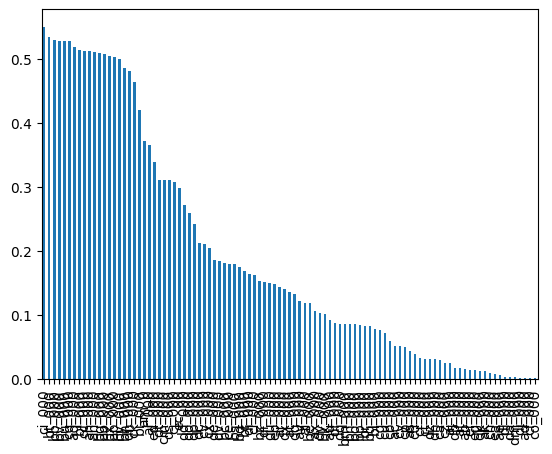

In [43]:

classes_trainning["label"].abs()[numerical_columns].sort_values(ascending=False).plot(kind='bar')
column_relevant = classes_trainning["label"].abs()[numerical_columns].sort_values(ascending=False) > 0.3


In [44]:
#get the columns that are relevant >.2
column_relevant = classes_trainning["label"].abs()[numerical_columns].sort_values(ascending=False) > 0.20
relevant_numerical_columns = column_relevant[column_relevant].index


In [45]:
#add two column types together
other_columns = pd.Index(classes_columns).append(pd.Index(relevant_numerical_columns))

In [46]:
#create neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

def get_model_for_aug_data(input_size= len(other_columns)):

    model = Sequential()
    model.add(Dense(64, input_dim=input_size, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-5), activity_regularizer=regularizers.l1(1e-5)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-5), activity_regularizer=regularizers.l1(1e-5)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-5), activity_regularizer=regularizers.l1(1e-5)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-5), activity_regularizer=regularizers.l1(1e-5)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-5), activity_regularizer=regularizers.l1(1e-5)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-5), activity_regularizer=regularizers.l1(1e-5)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-5), activity_regularizer=regularizers.l1(1e-5)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-5), activity_regularizer=regularizers.l1(1e-5)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-5), activity_regularizer=regularizers.l1(1e-5)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-5), activity_regularizer=regularizers.l1(1e-5)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-5), activity_regularizer=regularizers.l1(1e-5)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model




In [47]:
aug_model = get_model_for_aug_data()
X = set_training[other_columns].replace('na', 0).astype(float).values
X_transformed = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_transformed, target_value, test_size=0.33, random_state=42, stratify=target_value)


c:\Users\mt_er\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [48]:
aug_model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/100
315/315 [==============================] - 5s 9ms/step - loss: 0.3568 - accuracy: 0.9698 - val_loss: 0.1047 - val_accuracy: 0.9833
Epoch 2/100
315/315 [==============================] - 3s 8ms/step - loss: 0.1330 - accuracy: 0.9833 - val_loss: 0.0715 - val_accuracy: 0.9833
Epoch 3/100
315/315 [==============================] - 3s 8ms/step - loss: 0.0962 - accuracy: 0.9833 - val_loss: 0.0609 - val_accuracy: 0.9833
Epoch 4/100
315/315 [==============================] - 3s 8ms/step - loss: 0.0838 - accuracy: 0.9833 - val_loss: 0.0577 - val_accuracy: 0.9833
Epoch 5/100
315/315 [==============================] - 3s 8ms/step - loss: 0.0765 - accuracy: 0.9833 - val_loss: 0.0560 - val_accuracy: 0.9833
Epoch 6/100
315/315 [==============================] - 3s 8ms/step - loss: 0.0720 - accuracy: 0.9833 - val_loss: 0.0542 - val_accuracy: 0.9833
Epoch 7/100
315/315 [==============================] - 2s 7ms/step - loss: 0.0663 - accuracy: 0.9833 - val_loss: 0.0531 - val_accuracy: 0.9833

KeyboardInterrupt: 

In [49]:
#copy model for fine tuning
from keras.models import clone_model
aug_model_2 = clone_model(aug_model)
aug_model_2.set_weights(aug_model.get_weights())

In [50]:
target_prediction = aug_model.predict(X_test)
target_prediction = np.round(target_prediction)

print(classification_report(y_test, target_prediction))

print(confusion_matrix(y_test, target_prediction))


619/619 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19470
           1       0.83      0.48      0.61       330

    accuracy                           0.99     19800
   macro avg       0.91      0.74      0.80     19800
weighted avg       0.99      0.99      0.99     19800

[[19437    33]
 [  170   160]]


In [51]:
#finetune with a diffent objective function


import keras.backend as K

def weighted_binary_crossentropy(y_true, target_prediction):
    # Cast y_true to float32
    y_true = K.cast(y_true, 'float32')

    # Calculate the binary cross entropy
    bce = K.binary_crossentropy(y_true, target_prediction)

    # Define the weights
    weight_for_false_negatives = K.constant(500.0)  # Use keras constant for float
    weight_for_false_positives = K.constant(10.0)   # Use keras constant for float

    # Apply the weights
    weight_vector = y_true * weight_for_false_negatives + (1 - y_true) * weight_for_false_positives
    weighted_bce = weight_vector * bce

    return K.mean(weighted_bce)

adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

aug_model.compile(optimizer='adam', loss=weighted_binary_crossentropy, metrics=['accuracy'])

c:\Users\mt_er\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [52]:
target_prediction = aug_model.predict(X_test)

target_prediction = np.round(target_prediction)

print(classification_report(y_test, target_prediction))

print(confusion_matrix(y_test, target_prediction))

619/619 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19470
           1       0.83      0.48      0.61       330

    accuracy                           0.99     19800
   macro avg       0.91      0.74      0.80     19800
weighted avg       0.99      0.99      0.99     19800

[[19437    33]
 [  170   160]]


In [53]:
test_df

,id,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,1,60,0,20,12,0,0,0,0,0,...,1098,138,412,654,78,88,0,0,0,0
1,2,82,0,68,40,0,0,0,0,0,...,1068,276,1620,116,86,462,0,0,0,0
2,3,66002,2,212,112,0,0,0,0,0,...,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,4,59816,na,1010,936,0,0,0,0,0,...,540820,243270,483302,485332,431376,210074,281662,3232,0,0
4,5,1814,na,156,140,0,0,0,0,0,...,7646,4144,18466,49782,3176,482,76,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,15996,81852,na,2130706432,892,0,0,0,0,0,...,632658,273242,510354,373918,349840,317840,960024,25566,0,0
15996,15997,18,0,52,46,8,26,0,0,0,...,266,44,46,14,2,0,0,0,0,0
15997,15998,79636,na,1670,1518,0,0,0,0,0,...,806832,449962,778826,581558,375498,222866,358934,19548,0,0
15998,15999,110,na,36,32,0,0,0,0,0,...,588,210,180,544,1004,1338,74,0,0,0


In [54]:
#use test set to predict
log_df = test_df[numerical_columns].replace('na', 0).astype(float).apply(np.log)
log_df = log_df.replace(-np.inf, 0)
log_df = log_df.replace(np.inf, 0)
log_df = log_df.replace(np.nan, 0)

exp_df = test_df[numerical_columns].replace('na', 0).astype(float).apply(np.exp)
exp_df = exp_df.replace(-np.inf, 0)
exp_df = exp_df.replace(np.inf, 0)
exp_df = exp_df.replace(np.nan, 0)

#create a new pandas df with the log and exp columns and name them accordingly
log_df.columns = log_df.columns.map(lambda x: 'log_' + x)
exp_df.columns = exp_df.columns.map(lambda x: 'exp_' + x)

#concatenate the log and exp columns with the original df
test_df = pd.concat([test_df, log_df, exp_df], axis=1)

X = test_df[other_columns].replace('na', 0).astype(float).values


X_transformed = StandardScaler().fit_transform(X)
target_prediction_ = aug_model.predict(X_transformed)

output = pd.DataFrame({'id': np.arange(1,len(target_prediction_.reshape(-1))+1),"class": labelize(target_prediction_.reshape(-1))})
output.to_csv('categorical+relevant numerical values standardized neural network with custom obj func finetuned 20 epochs', index=False)


500/500 [==============================] - 1s 1ms/step


In [57]:
#lets do xgboost with the augmented data
import xgboost as xgb

clf = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=9,
    learning_rate=0.1,
    subsample=0.5,
    colsample_bytree=0.5,
    random_state=42,
    scale_pos_weight=1000,
)

clf.fit(X_train, y_train)
target_prediction = clf.predict(X_test)

print(classification_report(y_test, target_prediction))

print(confusion_matrix(y_test, target_prediction))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     19470
           1       0.73      0.85      0.79       330

    accuracy                           0.99     19800
   macro avg       0.86      0.92      0.89     19800
weighted avg       0.99      0.99      0.99     19800

[[19367   103]
 [   50   280]]


In [58]:
#define custom scoring for CV
from sklearn.metrics import make_scorer
def custom_cost_score(y_true, target_prediction):
    # Define your costs
    Cost_1 = 10  # Cost for false positives
    Cost_2 = 500  # Cost for false negatives

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, target_prediction).ravel()

    # Calculate the total cost
    total_cost = (Cost_1 * fp + Cost_2 * fn)
    return total_cost

# Create a scorer object
custom_scorer = make_scorer(custom_cost_score, greater_is_better=False)


In [59]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

X = set_training[other_columns].replace('na', 0).astype(float).values
X_transformed = StandardScaler().fit_transform(X)

# Define the parameter grid to search
param_grid = {
    'max_depth': [3, ],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.5, 1.0],
    'colsample_bytree': [0.5, 1.0],
    'scale_pos_weight': [5, 50 ,100, 500, 100]
}

# Initialize the XGBClassifier
clf = xgb.XGBClassifier(
    random_state=42,
    n_estimators=-1,
  )


# Create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=custom_scorer,
    cv=3,  # Number of cross-validation folds (3-fold cross-validation)
    verbose=3,
    n_jobs=-1  # Use all available cores
)

grid_search.fit(X_transformed, target_value)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=-1,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 1.0],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3],
                         'scale_pos_weight': [5, 50, 100, 500, 100],
                         'subsample': [0.5, 1.0]},
             scoring=make_scorer(custom_cost_score, greater_is_better=False),
             verbose=3)

In [230]:
grid_search.best_score_

18000.0

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, target_value, test_size=0.33, random_state=42, stratify=target_value)

clf = xgb.XGBClassifier(
    n_estimators=-1,
    random_state=42,

    **grid_search.best_params_
)

In [61]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=-1, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [62]:
target_prediction = clf.predict(X_test)

print(classification_report(y_test, target_prediction))

print(confusion_matrix(y_test, target_prediction))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19470
           1       0.00      0.00      0.00       330

    accuracy                           0.98     19800
   macro avg       0.49      0.50      0.50     19800
weighted avg       0.97      0.98      0.98     19800

[[19470     0]
 [  330     0]]


c:\Users\mt_er\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mt_er\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mt_er\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [65]:
#random forest
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, max_depth=6, random_state=42, class_weight={0: 1, 1: 500})
clf.fit(X_train, y_train)

target_prediction = clf.predict(X_test)

print(classification_report(y_test, target_prediction))

print(confusion_matrix(y_test, target_prediction))


              precision    recall  f1-score   support

           0       1.00      0.94      0.97     19470
           1       0.21      0.97      0.34       330

    accuracy                           0.94     19800
   macro avg       0.60      0.95      0.65     19800
weighted avg       0.99      0.94      0.96     19800

[[18249  1221]
 [   10   320]]


In [86]:
#random forest
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, max_depth=6, random_state=42, class_weight={0: 1, 1: 250})
clf.fit(X_train, y_train)

target_prediction = clf.predict(X_test)

print(classification_report(y_test, target_prediction))

print(confusion_matrix(y_test, target_prediction))


#use test set to predict
X = test_df[other_columns].replace('na', 0).astype(float).values
X_transformed = StandardScaler().fit_transform(X)
target_prediction_ = clf.predict(X_transformed)

output = pd.DataFrame({'id': np.arange(1,len(target_prediction_.reshape(-1))+1),"class": labelize(target_prediction_.reshape(-1))})
output.to_csv('randomforestLDA2.2.csv', index=False)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     19470
           1       0.23      0.96      0.37       330

    accuracy                           0.95     19800
   macro avg       0.61      0.95      0.67     19800
weighted avg       0.99      0.95      0.96     19800

[[18403  1067]
 [   13   317]]
